# CWT & STFT + CNN Model with Unicorn Hybrid Black dataset

In [39]:
import mne
import numpy as np
from mne.datasets import eegbci
import matplotlib.pyplot as plt
# from mne.channels import make_standard_montages

raw_each = [0] * 10
for i in range(0,10):
    raw_each[i] = mne.io.read_raw_edf("C:\git\Senior_Thesis\DataSet\Convert_data\hand"+ str(i) +"_new.edf",preload = True)

# raw_edf = mne.concatenate_raws([raw_each[0],raw_each[1],raw_each[2],raw_each[4],raw_each[5],raw_each[6]])
# raw_edf = mne.concatenate_raws([raw_each[0],raw_each[1],raw_each[4],raw_each[3]])
# raw_edf = mne.concatenate_raws([raw_each[2],raw_each[5],raw_each[6],raw_each[7]])
raw_edf = mne.concatenate_raws([raw_each[9]])

# raw_edf = mne.io.read_raw_edf("C:\git\Senior_Thesis\DataSet\Convert_data\MI_execution.edf", preload=True)

# eegbci.standardize(raw_edf)  # set channel names
# montage = make_standard_montage("standard_1005")
# raw_edf.set_montage(montage)

Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand0_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand1_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand2_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...


Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand3_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand4_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand5_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand6_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand7_n

In [40]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization, Activation, Dropout,LSTM,Reshape
from keras.models import Sequential
from keras.callbacks import History,ModelCheckpoint
from keras.utils import plot_model
history = History()
import pywt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mne.decoding import CSP
from mne.preprocessing import ICA
from sklearn.decomposition import FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit,StratifiedKFold ,cross_val_score, cross_val_predict, KFold
from ssqueezepy import ssq_cwt, ssq_stft
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [41]:
# eeg1 = raw_edf.copy().set_eeg_reference(ref_channels="average")
eeg1= raw_edf.pick(["Fz","C3", "Cz", "C4","Pz",'PO7','Oz','PO8'])
# eeg1= raw_edf.pick(["Fz","C3", "Cz", "C4",'PO7','Oz','PO8'])
component_num = 8

events, event_dict = mne.events_from_annotations(eeg1)
combine_epochs = mne.Epochs(eeg1, events, 
        tmin= -0.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 3.5,    # final timestamp (10 means set epoch duration 10 second)
        event_id=event_dict,
        preload = True,
        event_repeated='drop',
        baseline=(-0.5, 0)
    )
combine_epochs = combine_epochs.copy().crop(tmin=0.0, tmax=3.0)
# combine_epochs = combine_epochs.copy().filter(l_freq=12.0, h_freq=30.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'})

nonim_epochs2 = mne.Epochs(eeg1, events, 
        tmin= -2.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 0.5,    # final timestamp (10 means set epoch duration 10 second)
        event_id=event_dict,
        preload = True,
        event_repeated='drop',
        baseline=(-2.5, -2.0)
    )
nonim_epochs2 = nonim_epochs2.copy().crop(tmin=-2.0, tmax=0.0)
# nonim_epochs2 = nonim_epochs2.copy().filter(l_freq=6.0, h_freq=32.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'})

Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_GDF_Tongue', 'OVTK_GDF_Up', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_Train']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
608 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 608 events and 751 original time points ...
2 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
608 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 608 events and 

In [42]:
class_left = combine_epochs.event_id['OVTK_GDF_Left']
class_right = combine_epochs.event_id['OVTK_GDF_Right']
class_non = combine_epochs.event_id['OVTK_GDF_Tongue']
class_start_trial = combine_epochs.event_id['OVTK_GDF_Start_Of_Trial']
class_up = combine_epochs.event_id['OVTK_GDF_Up']

# select_classes = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Tongue'].get_data()
# labels = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Tongue'].events[:,2]

# TRY Slide Window for Classification for data 3s

In [43]:
select_classes_old = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Tongue']
labels_old = select_classes_old.events[:,2]
train_size = len(labels_old)
window_size_per_trial = 5
count_window = 0
select_classes = np.ndarray(shape=(train_size*window_size_per_trial, component_num, 501))
labels = np.ndarray(shape=train_size*window_size_per_trial)

for ii in range(0,train_size):
    for jj in range(0,window_size_per_trial):
        select_classes[jj+(window_size_per_trial*count_window)] = select_classes_old.get_data()[count_window,:,0+(25*jj):501+(25*jj)]   
        labels[jj+(window_size_per_trial*count_window)] = labels_old[count_window]
    count_window += 1

In [ ]:
select_classes.shape

In [44]:
combine_epochs.event_id

{'OVTK_GDF_Cross_On_Screen': 1,
 'OVTK_GDF_End_Of_Session': 2,
 'OVTK_GDF_End_Of_Trial': 3,
 'OVTK_GDF_Feedback_Continuous': 4,
 'OVTK_GDF_Left': 5,
 'OVTK_GDF_Right': 6,
 'OVTK_GDF_Start_Of_Trial': 7,
 'OVTK_GDF_Tongue': 8,
 'OVTK_GDF_Up': 9,
 'OVTK_StimulationId_BaselineStart': 10,
 'OVTK_StimulationId_BaselineStop': 11,
 'OVTK_StimulationId_Beep': 12,
 'OVTK_StimulationId_ExperimentStart': 13,
 'OVTK_StimulationId_Train': 14}

# CSP -> CWT -> CNN

In [45]:
#######################################################
for i in range(0,len(labels)):
    if labels[i] == class_left:
        labels[i] = 0
    elif labels[i] == class_right:
        labels[i] = 1
    elif labels[i] == class_non or labels[i] == class_start_trial:
        labels[i] = 2
    elif labels[i] == class_up:
        labels[i] = 3
        
train_data1 = select_classes

train_data2 = nonim_epochs2['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].get_data()
train_data = np.concatenate((train_data1, train_data2), axis=0)
labels = np.concatenate((labels,np.full((train_data2.shape[0],), 2)), axis = 0)

# train_data = train_data1

try csp+lda trined model

In [46]:
# csp2 = CSP(n_components=component_num, reg=None, log=None)
# csp2.fit(train_data, labels)
# with open('trained_csp2_model.pkl', 'wb') as file:
#     pickle.dump(csp2, file)

# with open('trained_csp2_model.pkl', 'rb') as file:
#     trained_csp2 = pickle.load(file)
# new_data2 = trained_csp2.transform(train_data)

# lda2 = LinearDiscriminantAnalysis()
# lda2.fit(new_data2, labels)
# with open('trained_lda_model.pkl', 'wb') as file:
#     pickle.dump(lda2, file)

# with open('trained_lda_model.pkl', 'rb') as file:
#     trained_lda = pickle.load(file)

    
# score = cross_val_score(trained_lda,new_data2, labels, cv= 10)
# lda_predicted = cross_val_predict(trained_lda, new_data2, labels, cv=10)
# conf_matrix = confusion_matrix(labels, lda_predicted)
# print("LDA only classification scores", score, np.mean(score))
# print(conf_matrix)

# score = trained_lda.score(new_data2, labels)
# lda_predicted = trained_lda.predict(new_data2)
# conf_matrix = confusion_matrix(labels, lda_predicted)
# print("LDA only classification scores", score)
# print(conf_matrix)


Computing rank from data with rank=None
    Using tolerance 1.3 (2.2e-16 eps * 8 dim * 7e+14  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3 (2.2e-16 eps * 8 dim * 7.3e+14  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.9 (2.2e-16 eps * 8 dim * 1.6e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
LDA only classification scores [0.9047619  0.95238095 0.9047619  0.71428571 0.85714286 0.80952381
 0.9047619  0.85714286 0.80952381 0.76190476] 0.8476190

train csp

In [47]:
csp = CSP(n_components=component_num, reg=None, log=None, transform_into='csp_space')
csp.fit(train_data, labels)

with open('trained_csp_newsess_NRL_model.pkl', 'wb') as file:
    pickle.dump(csp, file)

load csp

In [48]:
with open('trained_csp_newsess_NRL_model.pkl', 'rb') as file:
    trained_csp = pickle.load(file)

new_data = trained_csp.transform(train_data)
print(new_data.shape)

(210, 8, 501)


CWT

In [49]:
FB = 1
train_cwt = np.ndarray(shape=(new_data.shape[0], new_data.shape[2], component_num*FB))
for jj in range(0, new_data.shape[0]):
    train_cwt[jj] = new_data[jj].T
print(np.shape(train_cwt))

scales = range(1,31)

waveletname = 'morl'
train_size = len(labels)
train_data_cwt = np.ndarray(shape=(train_size, len(scales), new_data.shape[2], component_num*FB))

for ii in range(0,train_size):
    if ii % 200 == 0:
        print(ii)
    for jj in range(0,component_num*FB):
        signal = train_cwt[ii, :, jj]
        coeff, _ = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:new_data.shape[2]] 
        train_data_cwt[ii, :, :, jj] = abs(coeff_)
print(np.shape(train_data_cwt))

train_cwt_stack = np.ndarray(shape=(train_size, len(scales)*component_num*FB, new_data.shape[2]))

# train_cwt_stack = np.ndarray(shape=(train_size , new_data.shape[2], len(scales)*component_num*FB))

for jj in range(0,train_data_cwt.shape[0]):
    # train_cwt_stack[jj] = np.concatenate(train_data_cwt[jj], axis = 1)
    train_cwt_stack[jj] = np.vstack((train_data_cwt[jj,:,:,0], train_data_cwt[jj,:,:,1], train_data_cwt[jj,:,:,2], train_data_cwt[jj,:,:,3], train_data_cwt[jj,:,:,4], train_data_cwt[jj,:,:,5], train_data_cwt[jj,:,:,6],train_data_cwt[jj,:,:,7]))
    # train_cwt_stack[jj] = np.vstack((train_data_cwt[jj,:,:,0], train_data_cwt[jj,:,:,1], train_data_cwt[jj,:,:,2]))
print(np.shape(train_cwt_stack))

(210, 501, 8)
0


200
(210, 30, 501, 8)
(210, 240, 501)


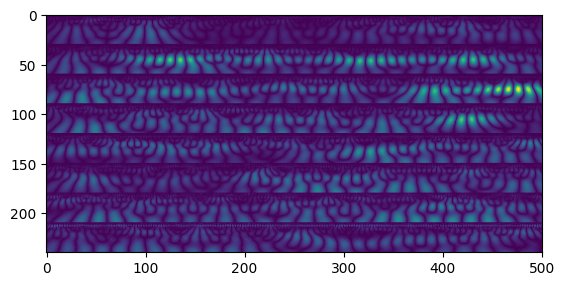

In [50]:
plt.imshow(train_cwt_stack[0])

In [51]:
outlier_trial = []
for ii in range(0,train_cwt_stack.shape[0]):
    if train_cwt_stack[ii].max() > 50:
        outlier_trial.append(ii)
        print(train_cwt_stack[ii].max(), ii)

200.0402901594265 68


In [52]:
train_cwt_stack = np.delete(train_cwt_stack, outlier_trial, axis = 0)
labels = np.delete(labels, outlier_trial)

Try scaler

In [53]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# reshaped_data = train_cwt_stack.reshape((train_cwt_stack.shape[0], -1))
# scaled_data = scaler.fit_transform(reshaped_data)
# scaled_data_3d = scaled_data.reshape(train_cwt_stack.shape)
# print(scaled_data_3d.shape)

In [54]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# scaler = MinMaxScaler()
# scaled_data =  np.ndarray(shape=(int(train_cwt_stack.shape[0]),int(train_cwt_stack.shape[1]),int(train_cwt_stack.shape[2])))
# for ii in range(0,train_cwt_stack.shape[0]):
#     scaled_data[ii] = scaler.fit_transform(train_cwt_stack[ii])

train_test split

In [55]:
# train_cwt_stack = scaled_data
x_train, x_test, y_train, y_test = train_test_split(train_cwt_stack, labels, test_size= 0.3, random_state = 42)

num_classes = len(np.unique(labels))
lowest = np.min(y_train)
batch_size = 1
epochs = 30
print(np.shape(x_train), np.shape(x_test), np.shape(y_train), np.shape(y_test))

y_train = keras.utils.to_categorical(y_train-lowest, num_classes)
y_test = keras.utils.to_categorical(y_test-lowest, num_classes)

(146, 240, 501) (63, 240, 501) (146,) (63,)


# Purposed CNN Model

In [56]:
# Define the CNN model
model = Sequential()

# Convolutional Layer 1 with 32 filters of kernel size 3x3
model.add(Conv2D(32, (3, 3), input_shape=(train_cwt_stack.shape[1], train_cwt_stack.shape[2],1), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional Layer 2 with 64 filters of kernel size 3x3
model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional Layer 3 with 128 filters of kernel size 3x3
model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))

# Flatten the output from the previous layer
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Reshape(target_shape=(1, 1024)))
model.add(LSTM(400, activation='relu'))

# Output Layer with the desired number of output nodes (adjust as needed)
model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(learning_rate= 0.0001), 
              metrics=['accuracy'])


plot_model(model,to_file='model_plot.png', show_shapes=True, show_layer_names=True)
checkpoint = ModelCheckpoint("CNN+RNN_model_newsess_NRL_slide_weights.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

model.fit(x_train, y_train, batch_size=batch_size, 
          epochs=epochs, verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[history, checkpoint])

7/7 [==============================] - 2s 241ms/step


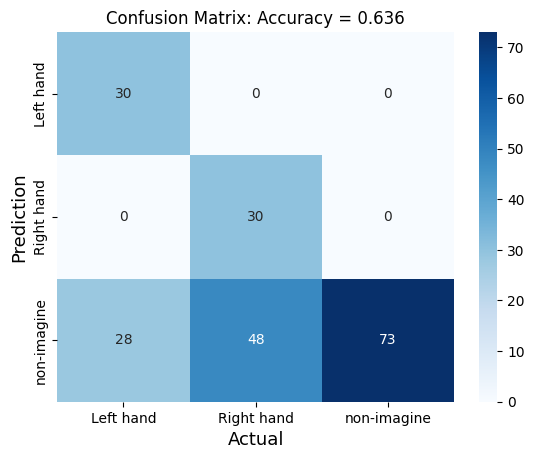

In [57]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
pretrained_model = load_model("CNN+RNN_model_newsess_NRL_slide_weights.h5")

y_test = keras.utils.to_categorical(labels-lowest, num_classes)

loss, accuracy = pretrained_model.evaluate(train_cwt_stack, y_test)

y_pred = pretrained_model.predict(train_cwt_stack)
y_pred = np.argmax(y_pred, axis=1) 
y_true = np.argmax(y_test, axis=1)

confusion_mat = confusion_matrix(y_true, y_pred)

# class_names = ['Left hand', 'Right hand',  'Non-imagine', 'Feet']

# class_names = ['Right hand','Non-imagine']

# class_names = ['Imagine','Non-imagine']

class_names = ['Left hand', 'Right hand', 'non-imagine']

# class_names = ['Left hand', 'Right hand', 'Up']

sns.heatmap(confusion_mat, 
            annot=True,
            fmt='d', 
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title("Confusion Matrix: Accuracy = "+ str(round(accuracy,3)))
plt.show()